# Lectura y Carga de Dataframe con Análisis de Sentimientos

In [1]:
from scipy.stats import wilcoxon
import statistics
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
import collections
from scipy.stats.stats import pearsonr
import pickle

######## SERVERS
# SPRING
# MONGO 
# APACHE 
# JBOSS 
# ATLASSIAN 

#***************
# Testing 
#***************

server = 'APACHE'
project = 'HADOOP'

issuesDataTest = pd.read_csv('repoDataSA/ISSUES-COMMENTS-' + server + '-' + project + '.csv')
issuesDataTest = issuesDataTest.sort_values(by=['issueComDate'])

print('Number of comments:', len(issuesDataTest))
print(issuesDataTest['sentiment'].value_counts('1')*100)

def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

del issuesDataTest['lenComment']
del issuesDataTest['self']
issuesDataTest.head()



Number of comments: 159907
 0    81.882594
 1    16.703459
-1     1.413947
Name: sentiment, dtype: float64


,author,comment,issueComDate,issueCreated,issueResolution,issuetype,key,resolution.date,summary,timeZone,sentiment
159647,sandstrom.p,fixes the problem by connecting to the NameNod...,2005-07-24T23:51:00.000+0000,2005-07-24T23:46:18.000+0000,Won't Fix,Bug,HADOOP-8,2006-02-24T08:13:30.000+0000,NDFS DataNode advertises localhost as it's add...,Etc/UTC,0
159608,rbt,"Wish there was an ""edit"" option in JIRA. Obvio...",2006-01-11T02:46:51.000+0000,2006-01-11T02:45:05.000+0000,Invalid,Bug,HADOOP-18,2006-03-07T06:30:32.000+0000,Crash with multiple temp directories,Etc/UTC,0
159609,cutting,I have sucessfully used mapred.local.dir with ...,2006-01-12T03:49:20.000+0000,2006-01-11T02:45:05.000+0000,Invalid,Bug,HADOOP-18,2006-03-07T06:30:32.000+0000,Crash with multiple temp directories,America/Los_Angeles,1
159650,michael_cafarella,Say! Here's a patch that implements the JobTra...,2006-01-21T05:42:08.000+0000,2006-01-21T05:40:53.000+0000,Fixed,Bug,HADOOP-7,2006-02-07T03:38:43.000+0000,MapReduce has a series of problems concerning ...,Etc/UTC,0
159651,byronm,"As Mr Burns would say ""eggcelent"" I'll give th...",2006-01-21T08:09:08.000+0000,2006-01-21T05:40:53.000+0000,Fixed,Bug,HADOOP-7,2006-02-07T03:38:43.000+0000,MapReduce has a series of problems concerning ...,Etc/UTC,0


# Function to Handle Duplicated Comments

In [2]:
# Handle Duplicated comments
exceptionComms = ['+1', 'looks good', 'Looks good.', 'Thanks!']

def handleDuplicatedComms(data):
    rows = []
    uniqueComms = []
    duplicComms = []

    for row in data.itertuples():
        if (str(row.comment) in set(uniqueComms)) and (str(row.comment) not in exceptionComms):
            duplicComms.append(row)
            continue
        rows.append(row)
        uniqueComms.append(str(row.comment))

    return pd.DataFrame(rows), pd.DataFrame(duplicComms)
    


#****************************
# Testing handleDuplications
#****************************
'''
uniqueComms, duplicComms = handleDuplications(comments)
print("****", len(uniqueComms), len(duplicComms))
print(duplicComms[dataset].value_counts('1')*100)
    
for row in duplicComms.itertuples():
    print(str(row.Jira), str(row.StackOverflow), str(row.comment))
'''

'\nuniqueComms, duplicComms = handleDuplications(comments)\nprint("****", len(uniqueComms), len(duplicComms))\nprint(duplicComms[dataset].value_counts(\'1\')*100)\n    \nfor row in duplicComms.itertuples():\n    print(str(row.Jira), str(row.StackOverflow), str(row.comment))\n'

# Function to plot data

In [3]:
def plot(data, sent='1', kind='line'):
    df = pd.DataFrame(data)
    ax = plt.gca()
    plt.xticks(np.arange(0, 200, 1))
    plt.yticks(np.arange(0, 200, 1))
    
    df.plot(kind=kind ,y=sent,ax=ax, figsize=(20,10))
    #df.plot(kind='line',y='-1', color='red', ax=ax)


# Sentiment Analysis per Hour of the Day

In [4]:

def sentimentsAndHourOfDay(issuesData = issuesDataTest, issueKeys = []):
    sentimentPerHour = {}
    
    for index, row in issuesData.iterrows():
        if (len(issueKeys)>0) and (row.key not in issueKeys):
            continue
            
        date = row['issueComDate'].split('.')[0]      
        dateComment = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S')
        hourComment = dateComment.hour
        sentiment = str(row['sentiment'])
            
        if hourComment in sentimentPerHour:
            sentimentPerHour[hourComment]['#'] += 1           
            
            if sentiment in sentimentPerHour[hourComment]:
                sentimentPerHour[hourComment][sentiment] += 1
            else: 
                sentimentPerHour[hourComment][sentiment] = 1       
            
        else:
            sentimentPerHour[hourComment] = {'#': 1, '1': 0, '-1': 0, '0': 0}
            sentimentPerHour[hourComment][sentiment] += 1
    
    return collections.OrderedDict(sorted(sentimentPerHour.items()))

      

OrderedDict([(0, {'#': 8058, '1': 18.71, '-1': 1.51, '0': 79.77}), (1, {'#': 6549, '1': 20.51, '-1': 1.63, '0': 77.86}), (2, {'#': 4768, '1': 19.4, '-1': 1.74, '0': 78.86}), (3, {'#': 4080, '1': 18.58, '-1': 1.74, '0': 79.68}), (4, {'#': 4621, '1': 18.09, '-1': 1.49, '0': 80.42}), (5, {'#': 5103, '1': 20.34, '-1': 1.61, '0': 78.05}), (6, {'#': 5062, '1': 20.25, '-1': 1.64, '0': 78.11}), (7, {'#': 4117, '1': 17.73, '-1': 1.72, '0': 80.54}), (8, {'#': 3840, '1': 16.9, '-1': 1.88, '0': 81.22}), (9, {'#': 4015, '1': 14.5, '-1': 2.07, '0': 83.44}), (10, {'#': 4672, '1': 11.39, '-1': 1.63, '0': 86.99}), (11, {'#': 5769, '1': 8.62, '-1': 1.35, '0': 90.03}), (12, {'#': 4767, '1': 9.63, '-1': 1.15, '0': 89.22}), (13, {'#': 5908, '1': 9.07, '-1': 1.15, '0': 89.78}), (14, {'#': 6191, '1': 10.05, '-1': 1.42, '0': 88.53}), (15, {'#': 6498, '1': 12.7, '-1': 1.83, '0': 85.47}), (16, {'#': 6924, '1': 17.46, '-1': 2.2, '0': 80.34}), (17, {'#': 9278, '1': 17.57, '-1': 1.91, '0': 80.52}), (18, {'#': 1141

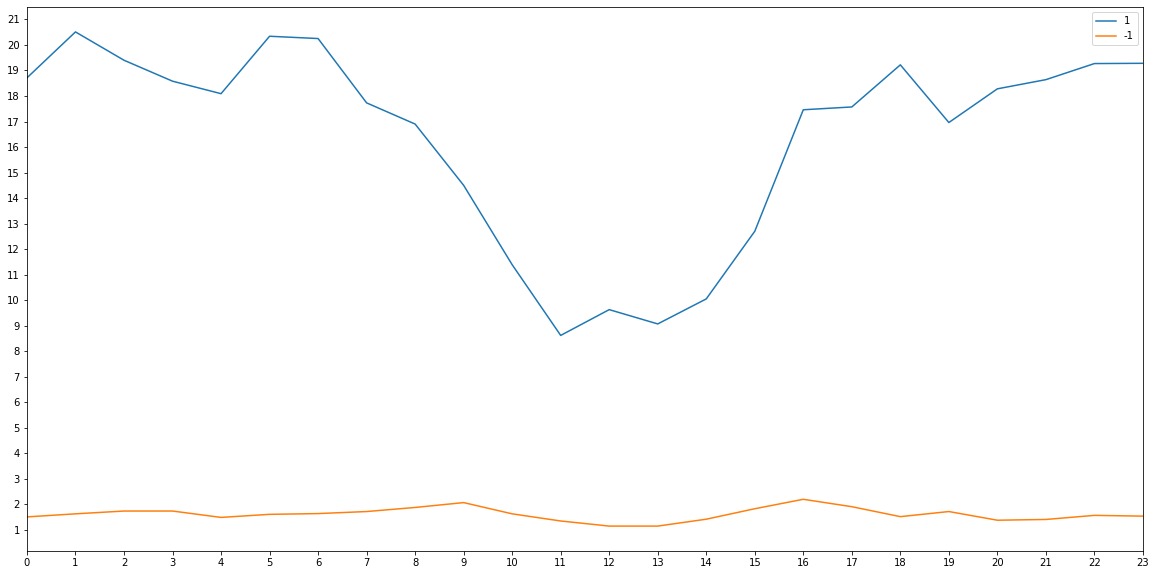

In [135]:
#*********************************
# Testing sentimentsAndHourOfDay
#*********************************

serversProjects = ['APACHE-CASSANDRA']

for s_p in serversProjects:
    issuesData = pd.read_csv('repoDataSA/ISSUES-COMMENTS-' + s_p + '.csv')
    #issueData, duplicComms = handleDuplicatedComms(issueData)
    plotSentPerHourDay = []
    sentimentPerHour = sentimentsAndHourOfDay(issuesData)

    for key, value in sentimentPerHour.items():
        if '1' in value:
            sentimentPerHour[key]['1']  = round((sentimentPerHour[key]['1'] / sentimentPerHour[key]['#']) * 100, 2)
        if '-1' in value:
            sentimentPerHour[key]['-1'] = round((sentimentPerHour[key]['-1'] / sentimentPerHour[key]['#']) * 100, 2)
        if '0' in value:
            sentimentPerHour[key]['0']  = round((sentimentPerHour[key]['0'] / sentimentPerHour[key]['#']) * 100, 2)
        plotSentPerHourDay.append(sentimentPerHour[key])

    print(sentimentPerHour)
    plot(plotSentPerHourDay, '1')
    plot(plotSentPerHourDay, '-1')

# Sentiment Analysis per Day of the Week

In [36]:
days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

def orderWeekDay(week):
    newOrder = {} 
    for day in days:
        for key, value in week.items():
            if day == key:
                newOrder[key] = value     
    return newOrder

def sentimentsAndDayOfWeek(issuesData = issuesDataTest, issueKeys = []):
    sentimentPerDay = {}
    weeks = []
    flag = False
    
    for index, row in issuesData.iterrows():
        if (len(issueKeys)>0) and (row.key not in issueKeys):
            continue
            
        date = row['issueComDate'].split('.')[0]
        dateComment = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S')
        dayComment = days[dateComment.weekday()]
        sentiment = str(row['sentiment'])
        
        week = str(dateComment.isocalendar()[1]) + '-' + str(dateComment.year)
        if week not in weeks:
            weeks.append(week)
            
        if dayComment in sentimentPerDay:
            sentimentPerDay[dayComment]['#'] += 1           
            
            if sentiment in sentimentPerDay[dayComment]:
                sentimentPerDay[dayComment][sentiment] += 1
            else: 
                sentimentPerDay[dayComment][sentiment] = 1       
            
        else:
            sentimentPerDay[dayComment] = {'#': 1, '1': 0, '-1': 0, '0': 0}
            sentimentPerDay[dayComment][sentiment] += 1
    
    #print('# Weeks: ', len(weeks), weeks)
    return sentimentPerDay




# Weeks:  577
{'Monday': {'#': 17398, '1': 11.58, '-1': 3.09, '0': 85.34}, 'Tuesday': {'#': 20866, '1': 12.24, '-1': 3.07, '0': 84.69}, 'Wednesday': {'#': 20742, '1': 12.87, '-1': 2.89, '0': 84.24}, 'Thursday': {'#': 19638, '1': 12.33, '-1': 2.91, '0': 84.76}, 'Friday': {'#': 18773, '1': 12.57, '-1': 2.74, '0': 84.69}, 'Saturday': {'#': 4787, '1': 9.88, '-1': 2.61, '0': 87.51}, 'Sunday': {'#': 3195, '1': 10.27, '-1': 2.57, '0': 87.17}}


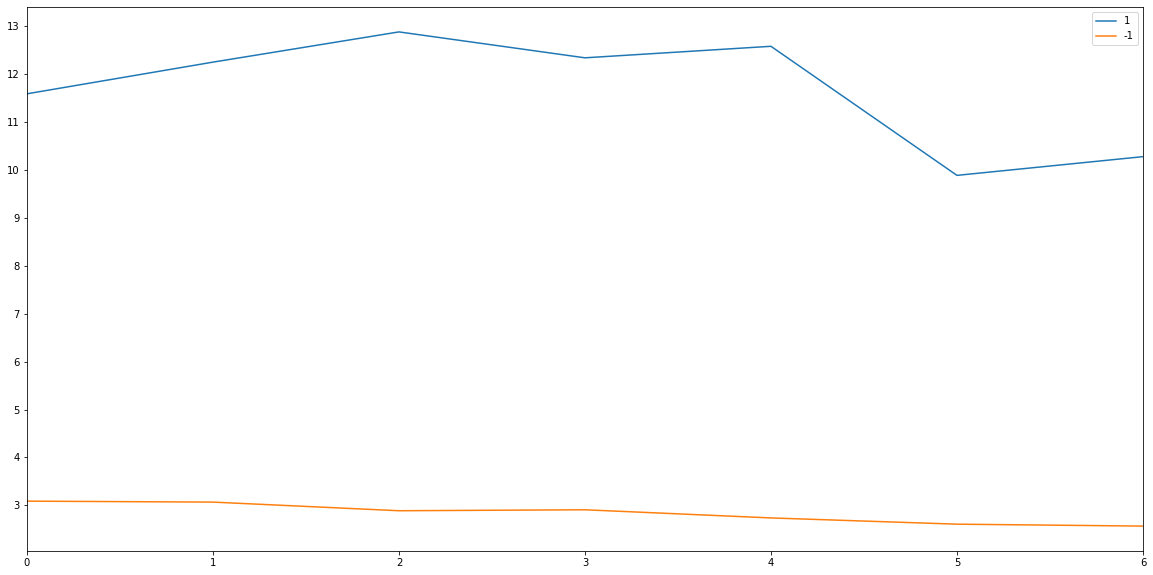

In [139]:
#*********************************
# Testing sentimentsAndDayOfWeek
#*********************************

serversProjects = ['APACHE-CASSANDRA']

for s_p in serversProjects:
    issuesData = pd.read_csv('repoDataSA/ISSUES-COMMENTS-' + s_p + '.csv') 
    #issuesData, duplicComms = handleDuplicatedComms(comts)
    plotSentPerWeekDay = [] 
    sentPerDay =  orderWeekDay(sentimentsAndDayOfWeek(issuesData))
    
    for key, value in sentPerDay.items():
        if '1' in value:
            sentPerDay[key]['1']  = round((sentPerDay[key]['1'] / sentPerDay[key]['#']) * 100, 2)
        if '-1' in value:
            sentPerDay[key]['-1'] = round((sentPerDay[key]['-1'] / sentPerDay[key]['#']) * 100, 2)
        if '0' in value:
            sentPerDay[key]['0']  = round((sentPerDay[key]['0'] / sentPerDay[key]['#']) * 100, 2)
        plotSentPerWeekDay.append(sentPerDay[key])

    print( sentPerDay )
    plot(plotSentPerWeekDay, '1')    
    plot(plotSentPerWeekDay, '-1')

# Sentiment Analysis per Timezone (Region)

In [6]:
def getTimeZones():
    timeZones = []

    for index, comment in comments.iterrows():
        if comment['timeZone'] not in timeZones:
            timeZones.append(comment['timeZone'])

    print(timeZones)
    return timeZones

def sentimentsAndTimeZone(issuesData = issuesDataTest):
    sentimentPerTimeZone = {}
    devsPerTimeZone = {}
    comtsPerDevTimeZone = {}
    flag = False
    
    for index, row in issuesData.iterrows():
        dev = row['author']
        comt = row['comment']
        timeZone = row['timeZone']
        sentiment = str(row['sentiment'])

        if timeZone in sentimentPerTimeZone:
            sentimentPerTimeZone[timeZone]['comts'] += 1           
                
            if sentiment in sentimentPerTimeZone[timeZone]:
                sentimentPerTimeZone[timeZone][sentiment] += 1
            else: 
                sentimentPerTimeZone[timeZone][sentiment] = 1  
                
            if dev not in devsPerTimeZone[timeZone]:
                sentimentPerTimeZone[timeZone]['devs'] += 1
                devsPerTimeZone[timeZone].append(dev)          
            
        else:
            sentimentPerTimeZone[timeZone] = {'comts': 1, 'devs': 1, '1': 0, '-1': 0, '0': 0}
            sentimentPerTimeZone[timeZone][sentiment] += 1
            devsPerTimeZone[timeZone] = [dev]
        
    for key, value in sentimentPerTimeZone.items():
        if '1' in value:
            sentimentPerTimeZone[key]['1']  = round((sentimentPerTimeZone[key]['1'] / sentimentPerTimeZone[key]['comts']) * 100, 2)
        else:
            sentimentPerTimeZone[key]['1'] = 0.0
        if '-1' in value:
            sentimentPerTimeZone[key]['-1'] = round((sentimentPerTimeZone[key]['-1'] / sentimentPerTimeZone[key]['comts']) * 100, 2)
        else:
            sentimentPerTimeZone[key]['-1'] = 0.0
        if '0' in value:
            sentimentPerTimeZone[key]['0']  = round((sentimentPerTimeZone[key]['0'] / sentimentPerTimeZone[key]['comts']) * 100, 2)
        else:
            sentimentPerTimeZone[key]['0'] = 0.0
    
    return sentimentPerTimeZone



0 {'comts': 84, 'devs': 10, '1': 29.76, '-1': 8.33, '0': 61.9, 'zone': 'America/Vancouver'}
1 {'comts': 69, 'devs': 2, '1': 31.88, '-1': 5.8, '0': 62.32, 'zone': 'Europe/Vienna'}
2 {'comts': 215, 'devs': 24, '1': 15.81, '-1': 5.12, '0': 79.07, 'zone': 'Europe/Moscow'}
3 {'comts': 14930, 'devs': 169, '1': 14.72, '-1': 4.6, '0': 80.68, 'zone': 'Europe/Berlin'}
4 {'comts': 596, 'devs': 2, '1': 14.77, '-1': 4.53, '0': 80.7, 'zone': 'Europe/Sofia'}
5 {'comts': 45, 'devs': 7, '1': 17.78, '-1': 4.44, '0': 77.78, 'zone': 'Europe/Rome'}
6 {'comts': 1347, 'devs': 8, '1': 33.63, '-1': 4.38, '0': 61.99, 'zone': 'America/Sao_Paulo'}
7 {'comts': 49, 'devs': 8, '1': 8.16, '-1': 4.08, '0': 87.76, 'zone': 'America/Havana'}
8 {'comts': 9641, 'devs': 40, '1': 15.82, '-1': 3.97, '0': 80.21, 'zone': 'Europe/London'}
9 {'comts': 268, 'devs': 4, '1': 32.46, '-1': 3.73, '0': 63.81, 'zone': 'Asia/Singapore'}
10 {'comts': 368, 'devs': 32, '1': 13.04, '-1': 3.53, '0': 83.42, 'zone': 'Europe/Paris'}
11 {'comts': 

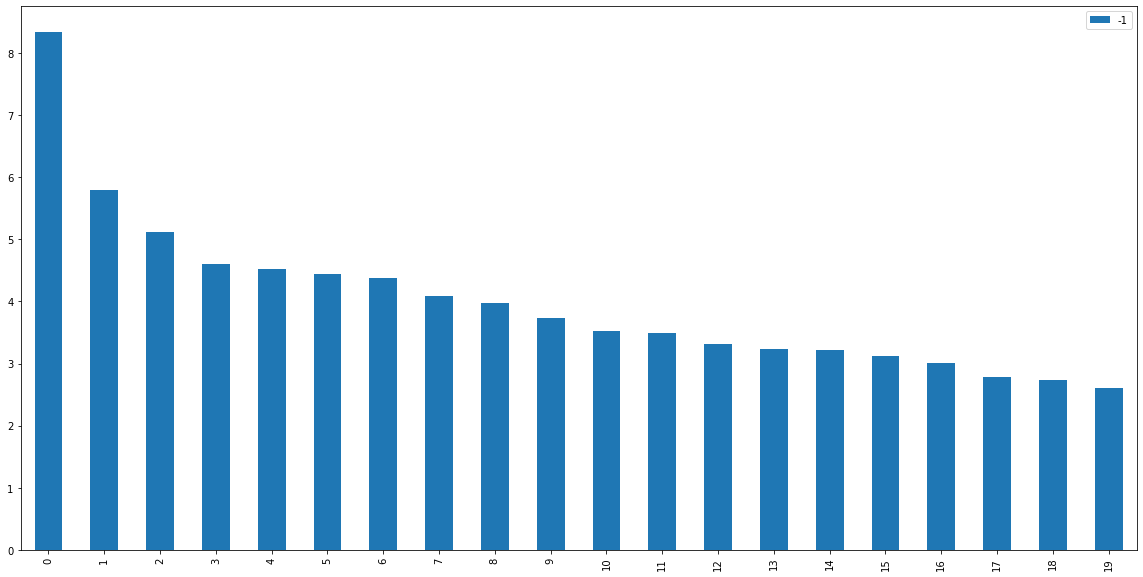

In [50]:
#*********************************
# Testing sentimentsAndTimeZone
#*********************************

serversProjects = ['APACHE-CASSANDRA']

for s_p in serversProjects:
    issuesData = pd.read_csv('repoDataSA/ISSUES-COMMENTS-' + s_p + '.csv') 
    #issuesData, duplicComms = handleDuplicatedComms(issuesData)
    sentsPerTimeZone = sentimentsAndTimeZone(issuesData)

#print( sentsPerTimeZone ) # print all (warning)
zones = []
for index, row in sentsPerTimeZone.items():
    if row['comts'] < 45:
        continue
    row['zone'] = index
    zones.append(row)

cnt = 0
order = '-1' # Pos (1) or Neg (-1)
numRows = 20 # Num of row to consider
zones = sorted(zones, key=lambda k: k[order], reverse=True)

for row in zones:
    if cnt >= numRows:
        break
    print(cnt, row)
    cnt += 1

plot(zones[:numRows], order, 'bar')

#  Sentiment Distro for a Project's Lifecycle

In [7]:
months=["1","2","3","4","5","6","7","8","9","10","11","12"]
# 1 -> Enero ... 12 -> Dic

def sentimentsDistroProjectLifecylce(issuesData = issuesDataTest, year = 'years'):
    sentProj = {}
    
    for index, row in issuesData.iterrows():
        date = row['issueComDate'].split('.')[0]
        dateComment = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S')
        sentiment = str(row['sentiment'])
        distroType = ''
        
        if (year == 'years'):
            distroType = str(dateComment.year)

        elif (year == str(dateComment.year)):
            #distroType = months[dateComment.month-1] + "_" + str(dateComment.year)    
            distroType = int(months[dateComment.month-1])
            
        else:
            continue
        
        if distroType in sentProj:
            sentProj[distroType]['numComms'] += 1           
            
            if sentiment in sentProj[distroType]:
                sentProj[distroType][sentiment] += 1
            else: 
                sentProj[distroType][sentiment] = 1       
            
        else:
            sentProj[distroType] = {'numComms': 1, '1': 0, '-1': 0, '0': 0}
            sentProj[distroType][sentiment] += 1
    
    for key, value in sentProj.items():
        if '1' in value:
            sentProj[key]['1']  = round((sentProj[key]['1'] / sentProj[key]['numComms']) * 100, 2)
        else:
            sentProj[key]['1'] = 0.0
        if '-1' in value:
            sentProj[key]['-1'] = round((sentProj[key]['-1'] / sentProj[key]['numComms']) * 100, 2)
        else:
            sentProj[key]['-1'] = 0.0
        if '0' in value:
            sentProj[key]['0']  = round((sentProj[key]['0'] / sentProj[key]['numComms']) * 100, 2)
        else:
            sentProj[key]['0'] = 0.0
 
    return sentProj



APACHE-CASSANDRA years
0 {'numComms': 4285, '1': 6.98, '-1': 1.98, '0': 91.04, 'date': '2009'}
1 {'numComms': 8108, '1': 6.36, '-1': 2.2, '0': 91.44, 'date': '2010'}
2 {'numComms': 12777, '1': 7.14, '-1': 2.57, '0': 90.29, 'date': '2011'}
3 {'numComms': 9534, '1': 8.67, '-1': 2.65, '0': 88.67, 'date': '2012'}
4 {'numComms': 9519, '1': 9.38, '-1': 3.03, '0': 87.59, 'date': '2013'}
5 {'numComms': 14955, '1': 10.12, '-1': 2.55, '0': 87.33, 'date': '2014'}
6 {'numComms': 17446, '1': 13.66, '-1': 3.22, '0': 83.13, 'date': '2015'}
7 {'numComms': 12903, '1': 18.35, '-1': 3.43, '0': 78.22, 'date': '2016'}
8 {'numComms': 7036, '1': 18.06, '-1': 3.74, '0': 78.2, 'date': '2017'}
9 {'numComms': 5309, '1': 19.63, '-1': 3.26, '0': 77.11, 'date': '2018'}
10 {'numComms': 2396, '1': 24.08, '-1': 3.67, '0': 72.25, 'date': '2019'}
11 {'numComms': 1131, '1': 19.36, '-1': 2.48, '0': 78.16, 'date': '2020'}


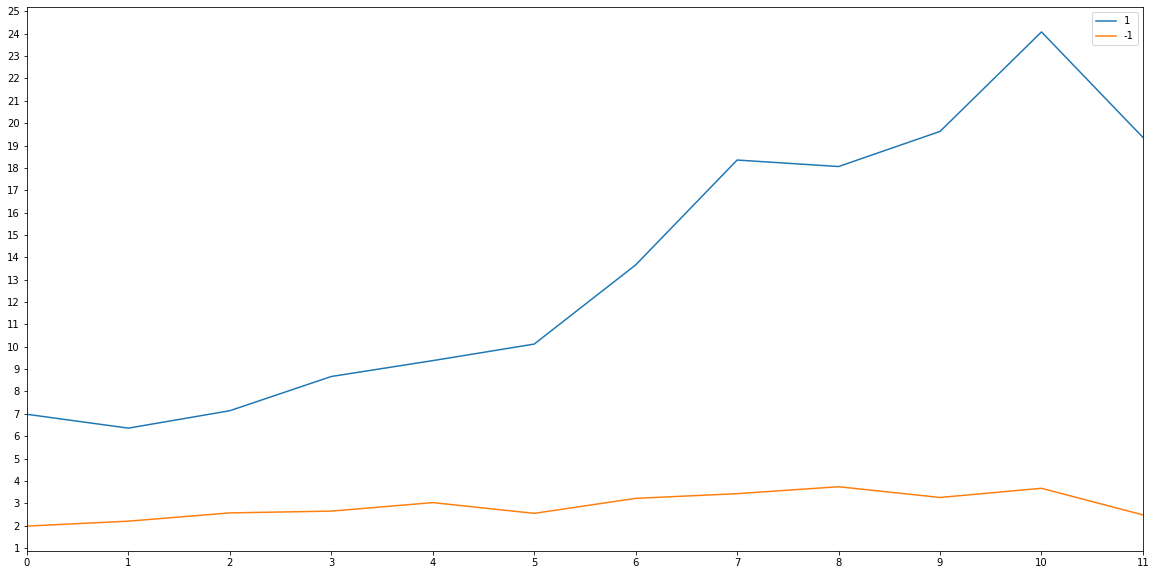

In [96]:
#******************************************
# Testing sentimentsDistroProjectLifecylce
#******************************************

serverProject = 'APACHE-CASSANDRA'
year = 'years'
# type 'YYYY' for that specific year (shows in months)
# type 'years' to show all years for the projects 

issuesData = pd.read_csv('repoDataSA/ISSUES-COMMENTS-' + serverProject + '.csv') 
#issuesData, duplicComms = handleDuplicatedComms(issuesData)
sentimentsDistro = sentimentsDistroProjectLifecylce(issuesData, year)

monthsYears = []
for index, row in sentimentsDistro.items():
    if row['numComms'] < 100:
        continue
    row['date'] = index
    monthsYears.append(row)
    

cnt = 0
numRows = len(monthsYears)
monthsYears = sorted(monthsYears, key=lambda k: k['date'], reverse=False)
print(serverProject, year,)

for row in monthsYears:
    if cnt >= numRows:
        break
    print(cnt, row)
    cnt += 1

if (len(monthsYears)>0):
    plot(monthsYears[:numRows], '1', 'line')
    plot(monthsYears[:numRows], '-1', 'line')
else:
    print('No data available')

# Configs

In [9]:

issuesResolutionDone    = ['Done', 'Fixed', 'Resolved', 'Resolved Locally', 'Answered', 'Deployed', 'Works as Designed', 'Community Answered', 'Implemented', "Complete"]
issuesResolutionNotDone = ["Won\'t Do", "Won\'t Fix", "Invalid", "Cannot Reproduce", "Incomplete", "Abandoned", "'Declined'", 'Duplicate', 'Gone away', 'Duplicate Issue', 'Out of Date', 'Rejected']

# ALL7(30)
serversProjectsV1 = [
                "MONGO-NODE","MONGO-PYTHON","MONGO-CSHARP","MONGO-MONGOID","MONGO-PHP",
                "MONGO-JAVA","MONGO-SERVER","MONGO-TOOLS","MONGO-RUBY","MONGO-WT", 
                "APACHE-ACCUMULO","APACHE-CASSANDRA","APACHE-MAPREDUCE","APACHE-IGNITE",
                "APACHE-STORM","APACHE-ATLAS","APACHE-BEAM","APACHE-DIRSERVER","APACHE-FELIX",
                "JBOSS-AEROGEAR", "JBOSS-DROOLS","JBOSS-RHBPMS","JBOSS-JBAS",
                "JBOSS-AS7","JBOSS-FUSETOOLS", 'JBOSS-JBPAPP',
                "SPRING-STS", "SPRING-BATCH", "SPRING-INT", "SPRING-ROO"
               ]


# ALL7(60),
serversProjectsV2 = [
                'APACHE-ACCUMULO','APACHE-ACE','APACHE-AMQNET','APACHE-ATLAS','APACHE-BEAM','APACHE-BIGTOP',
                'APACHE-CASSANDRA','APACHE-DIRSERVER','APACHE-FELIX','APACHE-GUMP','APACHE-HADOOP','APACHE-IGNITE',
                'APACHE-MAPREDUCE','APACHE-MATH','APACHE-STORM',
                #'ATLASSIAN-API','ATLASSIAN-BAM','ATLASSIAN-BCLOUD','ATLASSIAN-CLOUD','ATLASSIAN-CLOV',
                #'ATLASSIAN-CRUC','ATLASSIAN-CWD','ATLASSIAN-FE','ATLASSIAN-HCPUB','ATLASSIAN-JRACLOUD',
                #'ATLASSIAN-JRASERVER','ATLASSIAN-JSDCLOUD','ATLASSIAN-JSDSERVER','ATLASSIAN-SRCTREE',
                'JBOSS-AEROGEAR','JBOSS-AF','JBOSS-ARQ','JBOSS-AS7','JBOSS-DROOLS','JBOSS-ENTMQBR',
                'JBOSS-EXOJCR','JBOSS-FABRIC','JBOSS-FH','JBOSS-FORGE','JBOSS-FUSETOOLS','JBOSS-GTNPORTAL',
                'JBOSS-JBAS','JBOSS-JBESB','JBOSS-JBPAPP','JBOSS-JBTM','JBOSS-RHBPMS',
                'MONGO-CSHARP','MONGO-HADOOP','MONGO-JAVA','MONGO-MONGOID','MONGO-NODE','MONGO-PHP',
                'MONGO-PYTHON','MONGO-RUBY','MONGO-SERVER','MONGO-TOOLS','MONGO-WT',
                'SPRING-AMQP','SPRING-BATCH','SPRING-BATCHADM','SPRING-DATACMNS','SPRING-DATAGRAPH',
                'SPRING-DATAMONGO','SPRING-GRADLE','SPRING-GREENHOUSE','SPRING-IDE','SPRING-INT','SPRING-ROO',
                'SPRING-SGF','SPRING-SHDP','SPRING-SLICE','SPRING-SOCIAL','SPRING-SPRNET','SPRING-STS','SPRING-XD',
            ]


# Sentiments And Issue Resolution Type




******************************************** MONGO-NODE

>>> Config Proj
Num_Total_Issues:  1751
Num_Total_Coms:  6785
Distro_Sent:  {'#': 6785, '1': 9.92, '-1': 2.14, '0': 87.94}
ComsPer_Issue_Filter:  10
Num_Issues_Filter :  87
Num_Issues_Coms_Filter :  1488
NumOfID:   70 ( 81.4 )
NumOfIND:  16 ( 18.6 )

>>> Issues Done
Pos > Neg:  61  ( 87.14 )
Neg > Pos:  3  ( 4.29 )
Neg = Pos:  6  ( 8.57 )

>>> Issues Not Done
Pos > Neg:  10  ( 62.5 )
Neg > Pos:  4  ( 25.0 )
Neg = Pos:  2  ( 12.5 )

>>> Issues Resolution
      Pos  	 Neg  	 Neu 
ID:   16.15 	 2.76 	 81.09
IND:  15.09 	 5.64 	 79.27



******************************************** MONGO-PYTHON

>>> Config Proj
Num_Total_Issues:  1845
Num_Total_Coms:  6535
Distro_Sent:  {'#': 6535, '1': 9.72, '-1': 1.76, '0': 88.52}
ComsPer_Issue_Filter:  10
Num_Issues_Filter :  85
Num_Issues_Coms_Filter :  1327
NumOfID:   61 ( 72.62 )
NumOfIND:  23 ( 27.38 )

>>> Issues Done
Pos > Neg:  57  ( 93.44 )
Neg > Pos:  1  ( 1.64 )
Neg = Pos:  3  ( 4.92 




******************************************** APACHE-STORM

>>> Config Proj
Num_Total_Issues:  2575
Num_Total_Coms:  20446
Distro_Sent:  {'#': 20446, '1': 16.39, '-1': 2.04, '0': 81.56}
ComsPer_Issue_Filter:  10
Num_Issues_Filter :  487
Num_Issues_Coms_Filter :  13767
NumOfID:   474 ( 97.53 )
NumOfIND:  12 ( 2.47 )

>>> Issues Done
Pos > Neg:  430  ( 90.72 )
Neg > Pos:  17  ( 3.59 )
Neg = Pos:  27  ( 5.7 )

>>> Issues Not Done
Pos > Neg:  6  ( 50.0 )
Neg > Pos:  4  ( 33.33 )
Neg = Pos:  2  ( 16.67 )

>>> Issues Resolution
      Pos  	 Neg  	 Neu 
ID:   16.08 	 2.42 	 81.5
IND:  7.3 	 6.87 	 85.83



******************************************** APACHE-ATLAS

>>> Config Proj
Num_Total_Issues:  2853
Num_Total_Coms:  9788
Distro_Sent:  {'#': 9788, '1': 17.71, '-1': 0.64, '0': 81.65}
ComsPer_Issue_Filter:  10
Num_Issues_Filter :  128
Num_Issues_Coms_Filter :  2109
NumOfID:   125 ( 98.43 )
NumOfIND:  2 ( 1.57 )

>>> Issues Done
Pos > Neg:  125  ( 100.0 )
Neg > Pos:  0  ( 0.0 )
Neg = Pos:  


>>> Config Proj
Num_Total_Issues:  3367
Num_Total_Coms:  9683
Distro_Sent:  {'#': 9683, '1': 10.84, '-1': 1.88, '0': 87.28}
ComsPer_Issue_Filter:  10
Num_Issues_Filter :  109
Num_Issues_Coms_Filter :  1495
NumOfID:   96 ( 88.89 )
NumOfIND:  12 ( 11.11 )

>>> Issues Done
Pos > Neg:  82  ( 85.42 )
Neg > Pos:  7  ( 7.29 )
Neg = Pos:  7  ( 7.29 )

>>> Issues Not Done
Pos > Neg:  11  ( 91.67 )
Neg > Pos:  1  ( 8.33 )
Neg = Pos:  0  ( 0.0 )

>>> Issues Resolution
      Pos  	 Neg  	 Neu 
ID:   18.57 	 3.63 	 77.79
IND:  21.45 	 2.6 	 75.95



******************************************** SPRING-ROO

>>> Config Proj
Num_Total_Issues:  3618
Num_Total_Coms:  9595
Distro_Sent:  {'#': 9595, '1': 10.79, '-1': 1.94, '0': 87.27}
ComsPer_Issue_Filter:  10
Num_Issues_Filter :  102
Num_Issues_Coms_Filter :  1571
NumOfID:   80 ( 79.21 )
NumOfIND:  21 ( 20.79 )

>>> Issues Done
Pos > Neg:  71  ( 88.75 )
Neg > Pos:  4  ( 5.0 )
Neg = Pos:  5  ( 6.25 )

>>> Issues Not Done
Pos > Neg:  19  ( 90.48 )
Neg > Po

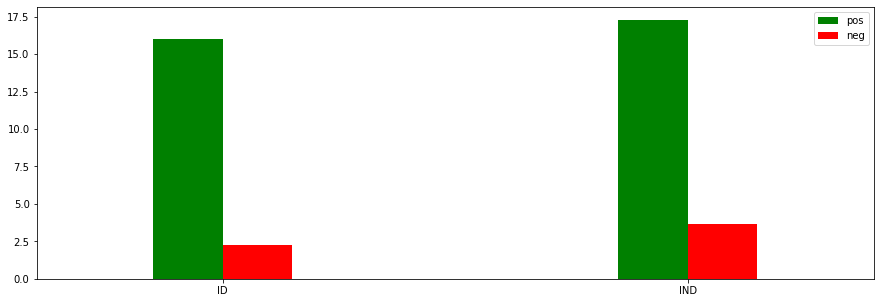

In [18]:

def sentimentsAndIssueResolutionType(repoProjects, numOfComsPerIssue = 20):
    #repoProjects = ['JBOSS-JBPAPP']
    
    countIssuesDoneMp, countIssuesDoneMn, countIssuesNotDoneMp, countIssuesNotDoneMn, countIssuesDoneEq, countIssuesNotDoneEq = 0, 0, 0, 0, 0, 0
    countTotalIssuesDoneMp, countTotalIssuesDoneMn, countTotalIssuesNotDoneMp, countTotalIssuesNotDoneMn, countTotalIssuesDoneEq, countTotalIssuesNotDoneEq = 0, 0, 0, 0, 0, 0
    sumaID, sumaIND, sumaTotalID, sumaTotalIND, countTotalID, countTotalIND, countComsPerIssues = 0, 0, 0, 0, 0, 0, 0
    sumTotalPromPosID, sumTotalPromNegID, sumTotalPromNeuID, sumTotalPromPosIND, sumTotalPromNegIND, sumTotalPromNeuIND = 0, 0, 0, 0, 0, 0
    totalIssues = 0
    totalComs = 0
    totalComsFilter = 0
    numOfComsPerIssue = numOfComsPerIssue
    distroTotalSent = {"#": 0, '1': 0, '-1': 0, '0': 0}
    issuesType, issuesTypeID, issuesTypeIND  = {}, {}, {}
    
    for proj in repoProjects:
        countPos, countNeg, countIR, cntComsPerIssue = 0, 0, 0, 0
        countID, countIND, sumPromPosID, sumPromNegID, sumPromNeuID, sumPromPosIND, sumPromNegIND, sumPromNeuIND = 0, 0, 0, 0, 0, 0, 0, 0
        countIssuesDoneMp, countIssuesDoneMn, countIssuesNotDoneMp, countIssuesNotDoneMn, countIssuesDoneEq, countIssuesNotDoneEq = 0, 0, 0, 0, 0, 0
        comsPerIssues, issuesResolution, issues = {}, {}, {}
        distroSent = {"#": 0, '1': 0, '-1': 0, '0': 0}      

        comts = pd.read_csv('repoDataSA/ISSUES-COMMENTS-' + proj + '.csv')
        #comts = pd.read_csv('../SentiCR/SentimentAnalysis/ISSUES-COMMENTS-' + proj + '.csv')
        
        comts = comts.sort_values(by=['issueComDate'])

        print('\n\n\n********************************************', proj)
        numCom = len(comts)
        totalComs += numCom
        #print(comts['sentiment'].value_counts('1')*100 )
        
        for index, comment in comts.iterrows():
            sent = str(comment['sentiment'])
            
        # Get distro sentiment (pos, neg, neu)
            distroSent["#"] += 1
            distroSent[sent] += 1
            distroTotalSent["#"] += 1
            distroTotalSent[sent] += 1
        
        # Get Issues
            if comment.key in issues: 
                issues[comment.key] += 1 
            else:
                issues[comment.key] = 1         

        # Get Comments per Issues
            if comment.key in comsPerIssues:
                comsPerIssues[comment.key]['#'] += 1
                comsPerIssues[comment.key][sent] += 1
                comsPerIssues[comment.key]['rows'].append(comment) 
            else:
                #comsPerIssues[comment.key] = comment.key
                comsPerIssues[comment.key] = {'#': 1, '1': 0, '-1': 0, '0': 0, 'res': comment.issueResolution, 'rows': [comment]}
                comsPerIssues[comment.key][sent] += 1

        for comsPerIssue in comsPerIssues.copy():
        
        # Filter issues less than numOfComsPerIssue
            if comsPerIssues[comsPerIssue]['#'] < numOfComsPerIssue or (comsPerIssues[comsPerIssue]['1'] == 0 and comsPerIssues[comsPerIssue]['-1'] == 0):
               del comsPerIssues[comsPerIssue]
               continue; 
            
            if comsPerIssues[comsPerIssue]['rows'][0].key not in issuesKeys:
                issuesKeys.append(comsPerIssues[comsPerIssue]['rows'][0].key)
                
            cntComsPerIssue += comsPerIssues[comsPerIssue]['#']
            totalComsFilter += comsPerIssues[comsPerIssue]['#']
        
        # Get Issues Types  
            issType = comsPerIssues[comsPerIssue]['rows'][0].issuetype 
            numC, posC= comsPerIssues[comsPerIssue]['#'] , comsPerIssues[comsPerIssue]['1'],
            negC, neuC = comsPerIssues[comsPerIssue]['-1'], comsPerIssues[comsPerIssue]['0'] 
            
            if issType in issuesType:
                issuesType[issType]['#'] += numC  
                issuesType[issType]['1'] += posC
                issuesType[issType]['-1'] += negC
                issuesType[issType]['0'] += neuC 
            else:
                issuesType[issType] = {'#': numC, '1': posC, '-1': negC, '0': neuC}
                    
            if comsPerIssues[comsPerIssue]['res'] in issuesResolutionDone:   
                if issType in issuesTypeID:
                    issuesTypeID[issType]['#'] += numC    
                    issuesTypeID[issType]['1'] += posC
                    issuesTypeID[issType]['-1'] += negC
                    issuesTypeID[issType]['0'] += neuC 
                else:
                    issuesTypeID[issType] = {'#': numC, '1': posC, '-1': negC, '0': neuC}

            if comsPerIssues[comsPerIssue]['res'] in issuesResolutionNotDone:
                if issType in issuesTypeIND:
                    issuesTypeIND[issType]['#'] += numC     
                    issuesTypeIND[issType]['1'] += posC
                    issuesTypeIND[issType]['-1'] += negC
                    issuesTypeIND[issType]['0'] += neuC   
                else:
                    issuesTypeIND[issType] = {'#': numC, '1': posC, '-1': negC, '0': neuC}
                
        # Calculate average for each sentiment
            comsPerIssues[comsPerIssue]['1']  = round((comsPerIssues[comsPerIssue]['1']/comsPerIssues[comsPerIssue]['#']) * 100, 2)
            comsPerIssues[comsPerIssue]['-1'] = round((comsPerIssues[comsPerIssue]['-1']/comsPerIssues[comsPerIssue]['#']) * 100, 2)
            comsPerIssues[comsPerIssue]['0']  = round((comsPerIssues[comsPerIssue]['0']/comsPerIssues[comsPerIssue]['#']) * 100, 2)  
        
        # Assign each issue resolution to Issue Done
            if comsPerIssues[comsPerIssue]['res'] in issuesResolutionDone:
                comsPerIssues[comsPerIssue]['res'] = 'ID'
                sumPromPosID += comsPerIssues[comsPerIssue]['1'] 
                sumPromNegID += comsPerIssues[comsPerIssue]['-1']
                sumPromNeuID += comsPerIssues[comsPerIssue]['0']
                sumTotalPromPosID += comsPerIssues[comsPerIssue]['1'] 
                sumTotalPromNegID += comsPerIssues[comsPerIssue]['-1']
                sumTotalPromNeuID += comsPerIssues[comsPerIssue]['0']
                countTotalID += 1
                countID += 1
                
                if comsPerIssues[comsPerIssue]['1'] > comsPerIssues[comsPerIssue]['-1']:
                    countIssuesDoneMp += 1
                    countTotalIssuesDoneMp += 1
                elif comsPerIssues[comsPerIssue]['-1'] > comsPerIssues[comsPerIssue]['1']:
                    countIssuesDoneMn += 1
                    countTotalIssuesDoneMn += 1
                else:
                    countIssuesDoneEq += 1
                    countTotalIssuesDoneEq += 1

        # Assign each issue resolution to Issue Not Done
            elif comsPerIssues[comsPerIssue]['res'] in issuesResolutionNotDone:
                comsPerIssues[comsPerIssue]['res'] = 'IND'
                sumPromPosIND += comsPerIssues[comsPerIssue]['1']
                sumPromNegIND += comsPerIssues[comsPerIssue]['-1']
                sumPromNeuIND += comsPerIssues[comsPerIssue]['0']
                sumTotalPromPosIND += comsPerIssues[comsPerIssue]['1']
                sumTotalPromNegIND += comsPerIssues[comsPerIssue]['-1']
                sumTotalPromNeuIND += comsPerIssues[comsPerIssue]['0']
                countTotalIND += 1
                countIND += 1
                
                if comsPerIssues[comsPerIssue]['1'] > comsPerIssues[comsPerIssue]['-1']:
                    countIssuesNotDoneMp += 1
                    countTotalIssuesNotDoneMp += 1
                elif comsPerIssues[comsPerIssue]['-1'] > comsPerIssues[comsPerIssue]['1']:
                    countIssuesNotDoneMn += 1
                    countTotalIssuesNotDoneMn += 1
                else:
                    countIssuesNotDoneEq += 1
                    countTotalIssuesNotDoneEq += 1
                    
            else:
                del comsPerIssues[comsPerIssue]
        
        
        distroSent['1'] = round((distroSent['1']/distroSent['#'])*100, 2)
        distroSent['-1'] = round((distroSent['-1']/distroSent['#'])*100, 2)
        distroSent['0'] = round((distroSent['0']/distroSent['#'])*100, 2)
        countComsPerIssues += len(comsPerIssues)
        totalIssues += len(issues)
        
        sumaID  = countIssuesDoneMp + countIssuesDoneMn + countIssuesDoneEq
        sumaIND = countIssuesNotDoneMp + countIssuesNotDoneMn + countIssuesNotDoneEq
        
        
        print ("\n>>> Config Proj")
        print("Num_Total_Issues: ", len(issues)+1)
        print("Num_Total_Coms: ", numCom)
        print("Distro_Sent: ", distroSent)
        print("ComsPer_Issue_Filter: ", numOfComsPerIssue)
        print("Num_Issues_Filter : ", len(comsPerIssues)+1)
        print("Num_Issues_Coms_Filter : ", cntComsPerIssue)
        
        if (len(comsPerIssues) != 0):
            print("NumOfID:  ", countID, "(", round((countID/len(comsPerIssues))*100, 2), ")")
            print("NumOfIND: ", countIND, "(", round((countIND/len(comsPerIssues))*100, 2), ")")
        
        print("\n>>> Issues Done")
        if sumaID != 0:
            print("Pos > Neg: ", countIssuesDoneMp, ' (', round((countIssuesDoneMp/sumaID)*100, 2), ')')
            print("Neg > Pos: ", countIssuesDoneMn, ' (', round((countIssuesDoneMn/sumaID)*100, 2), ')')
            print("Neg = Pos: ", countIssuesDoneEq, ' (', round((countIssuesDoneEq/sumaID)*100, 2), ')')
        
        print("\n>>> Issues Not Done")
        if sumaIND != 0:
            print("Pos > Neg: ", countIssuesNotDoneMp, ' (', round((countIssuesNotDoneMp/sumaIND)*100, 2), ')')
            print("Neg > Pos: ", countIssuesNotDoneMn, ' (', round((countIssuesNotDoneMn/sumaIND)*100, 2), ')')
            print("Neg = Pos: ", countIssuesNotDoneEq, ' (', round((countIssuesNotDoneEq/sumaIND)*100, 2), ')')
        
        print ("\n>>> Issues Resolution")
        print("      Pos ", "\t Neg ", "\t Neu ")
        if countID != 0:
            print("ID:  ", round(sumPromPosID/countID, 2), "\t", round(sumPromNegID/countID, 2), "\t", round(sumPromNeuID/countID, 2))
        if countIND != 0:
            print("IND: ", round(sumPromPosIND/countIND, 2), "\t", round(sumPromNegIND/countIND, 2), "\t", round(sumPromNeuIND/countIND, 2))
       
        
        #print("\n", len(comsPerIssues), comsPerIssues)
        if bool(comsPerIssues) == True:
            #issueAnalytics(comsPerIssues)
            #corrPearson([comsPerIssues])
            if str(numOfComsPerIssue) in comsPerIssuesArr:
                comsPerIssuesArr[str(numOfComsPerIssue)].append(comsPerIssues)
            else: 
                comsPerIssuesArr[str(numOfComsPerIssue)] = [comsPerIssues]
    
    print("\n\n*** Total")
    sumaTotalID  = countTotalIssuesDoneMp + countTotalIssuesDoneMn + countTotalIssuesDoneEq
    sumaTotalIND = countTotalIssuesNotDoneMp + countTotalIssuesNotDoneMn + countTotalIssuesNotDoneEq
    
    distroTotalSent['1'] = round((distroTotalSent['1']/distroTotalSent['#'])*100, 2)
    distroTotalSent['-1'] = round((distroTotalSent['-1']/distroTotalSent['#'])*100, 2)
    distroTotalSent['0'] = round((distroTotalSent['0']/distroTotalSent['#'])*100, 2)
        
    print ("\n>>> Config")
    print("TotalIssues: ", totalIssues)
    print("TotalComms : ", totalComs)
    print("DistroTotalSent: ", distroTotalSent)
    print("ComsFilter: ", numOfComsPerIssue)
    print("issuesKeys: ", len(issuesKeys))
    print("NumOfIssuesFilter : ", countComsPerIssues)
    print("NumOfComsIssuesFilter : ", totalComsFilter)
    print("NumOfID:  ", countTotalID, "(", round((countTotalID/countComsPerIssues)*100, 2), ")")
    print("NumOfIND: ", countTotalIND, "(", round((countTotalIND/countComsPerIssues)*100, 2), ")")
        
    print("\n>>> Issues Done")
    if sumaTotalID != 0:
        print("Pos > Neg: ", countTotalIssuesDoneMp, ' (', round((countTotalIssuesDoneMp/sumaTotalID)*100, 2), ')')
        print("Neg > Pos: ", countTotalIssuesDoneMn, ' (', round((countTotalIssuesDoneMn/sumaTotalID)*100, 2), ')')
        print("Neg = Pos: ", countTotalIssuesDoneEq, ' (', round((countTotalIssuesDoneEq/sumaTotalID)*100, 2), ')')
    print("\n>>> Issues Not Done")
    if sumaTotalIND != 0:
        print("Pos > Neg: ", countTotalIssuesNotDoneMp, ' (', round((countTotalIssuesNotDoneMp/sumaTotalIND)*100, 2), ')')
        print("Neg > Pos: ", countTotalIssuesNotDoneMn, ' (', round((countTotalIssuesNotDoneMn/sumaTotalIND)*100, 2), ')')
        print("Neg = Pos: ", countTotalIssuesNotDoneEq, ' (', round((countTotalIssuesNotDoneEq/sumaTotalIND)*100, 2), ')')
    
    print ("\n>>> Issues Resolution Sents")
    print("      Pos ", "\t Neg ", "\t Neu ")
    if countTotalID != 0:
        print("ID:  ", round(sumTotalPromPosID/countTotalID, 2), "\t", round(sumTotalPromNegID/countTotalID, 2), "\t", round(sumTotalPromNeuID/countTotalID, 2))
    if countTotalIND != 0:
        print("IND: ", round(sumTotalPromPosIND/countTotalIND, 2), "\t", round(sumTotalPromNegIND/countTotalIND, 2), "\t", round(sumTotalPromNeuIND/countTotalIND, 2))
    
    #corrPearson(comsPerIssuesArr[str(numOfComsPerIssue)])
    
    print ("\n>>> Issues Types")    
    print ("> Done")
    for key, value in issuesTypeID.items():
        issuesTypeID[key]['1']  = round((value['1'] /value['#']) * 100, 2)
        issuesTypeID[key]['-1'] = round((value['-1']/value['#']) * 100, 2)
        issuesTypeID[key]['0']  = round((value['0'] /value['#']) * 100, 2)        
    print (issuesTypeID)
    
    print ("> Not Done")
    for key, value in issuesTypeIND.items():
        issuesTypeIND[key]['1']  = round((value['1'] /value['#']) * 100, 2)
        issuesTypeIND[key]['-1'] = round((value['-1']/value['#']) * 100, 2)
        issuesTypeIND[key]['0']  = round((value['0'] /value['#']) * 100, 2)
    print(issuesTypeIND)
    
    #Plot Issues Resolution
    df = pd.DataFrame({
                        'pos': [round(sumTotalPromPosID/countTotalID, 2), round(sumTotalPromPosIND/countTotalIND, 2)],
                        'neg': [round(sumTotalPromNegID/countTotalID, 2), round(sumTotalPromNegIND/countTotalIND, 2)],
                        #'neu': sentNeu
                      }, 
                      index=['ID', 'IND']
                    )
    ax = df.plot(kind='bar', color=('green', 'red'), rot=0, width=0.3, figsize=(15,5))

    
    

comsPerIssuesArr = {}
issuesKeys = []
numComs = [0, 10, 20, 30, 40, 50]    

'''
for n in numComs:  
    sentimentsAndIssueResolutionType(serversProjectsV1, n)

'''
sentimentsAndIssueResolutionType(serversProjectsV1, numComs[1])




In [19]:
# Store Data:
'''f = open('pickles/sentimentsAndIssueResolutionType_From_0_to_100_Comms.pckl', 'wb')
pickle.dump(comsPerIssuesArr, f)
f.close()'''

"f = open('pickles/sentimentsAndIssueResolutionType_From_0_to_100_Comms.pckl', 'wb')\npickle.dump(comsPerIssuesArr, f)\nf.close()"

In [20]:
# Get Data (dataset_RepoName_ToolName):
'''f = open('pickles/sentimentsAndIssueResolutionType_From_0_to_100_Comms.pckl', 'rb')
comsPerIssuesArr = pickle.load(f)
f.close()'''

"f = open('pickles/sentimentsAndIssueResolutionType_From_0_to_100_Comms.pckl', 'rb')\ncomsPerIssuesArr = pickle.load(f)\nf.close()"

# Sentiments And Issue Resolution Time

In [25]:
# Es necesario ejecutar sentimentsAndIssueResolutionType() antes de este análisis

def sentimentsAndIssueResolutionTime(comsPerIssuesArr, issRes):
    print("\n")
    days, devs, sentPOS, sentNEG, sentNEU = [], [], [], [], []
    numTotComs = 0

    if len(comsPerIssuesArr) == 0:
        return
    
    for comsPerIssues in comsPerIssuesArr:
        for key, row in comsPerIssues.items():  
        
            if (
                isinstance(row['rows'][0]['resolution.date'], str) 
                #and row['rows'][0].issuetype == 'Improvement'
                #and key.split('-')[0] == 'CASSANDRA'
            ):
                initIssueDate = datetime.strptime(row['rows'][0].issueCreated.split('.')[0], '%Y-%m-%dT%H:%M:%S')
                endIssueDate  = datetime.strptime(row['rows'][0]['resolution.date'].split('.')[0], '%Y-%m-%dT%H:%M:%S')
                issueTime = abs((endIssueDate - initIssueDate).days)
            
            # Get number of devs per issue
                devs=[]
                numDevs = 0
                for r in row['rows']:
                    if r.author in devs:
                        numDevs+=1
                    else:
                        numDevs = 1
                        devs.append(r.author)
                row['devs'] = numDevs
            
            # Issues Done analysis
                if (
                        issRes == 'ID'
                        and row['res'] == issRes
                        and issueTime<125
                        and row['devs']>1
                        and row['1']>0
                        and row['1']<40
                        and not (row['1']>28 and issueTime>60)
                        and not (row['1']>24 and issueTime>100)
                        and not (row['1']>20 and issueTime>120)
                        and row['-1']>0
                        and row['-1']<14
                        and not (row['-1']>9 and issueTime>110)
                        and row['0']>0
                        and row['0']<100
                        and not (row['0']<65 and issueTime>40)
                    ): 

                        '''print(key, len(row['rows']), ' --- ', 
                              row['1'], ' / ', row['-1'], ' / ', row['0'], ' / ', 
                              row['res'], ' / ',  row['rows'][0].issuetype
                             )
                        ID_ISSUES = []
                        if key in ID_ISSUES:   
                            print(key, '\n----------------------------------------------------------------------------\n')
                            for r in row['rows']:
                               # if r['sentiment'] != 0:
                                print(r['sentiment'], r['issueComDate'], r['author'], r['comment'],  '\n')'''


                        numTotComs += len(row['rows'])
                        days.append(issueTime)
                        devs.append(row['devs'])
                        sentNEU.append(row['0'])
                        sentPOS.append(row['1'])
                        sentNEG.append(row['-1'])

                        globDevs_ID.append(row['devs'])
                        globDays_ID.append(issueTime)
                        globSentPOS_ID.append(row['1'])
                        globSentNEG_ID.append(row['-1'])
                        globSentNEU_ID.append(row['0'])
                        
            # Issues Not Done analysis   
                if (
                        issRes == 'IND'
                        and row['res'] == issRes
                        and issueTime>0
                        and issueTime<200
                        and row['devs']>1
                        and row['1']>0
                        and row['1']<40
                        and not (row['1']>35 and issueTime>75)
                        and not (row['1']>25 and issueTime>100)
                        and not (row['1']>15 and issueTime>170)
                        and row['-1']>0
                        and row['-1']<15
                        and not (row['-1']>11 and issueTime>50)
                        and not (row['-1']>9 and issueTime>150)
                        and row['0']>50
                        and row['0']<100
                        and not (row['0']<76 and issueTime>110)

                    ): 
                    
                        '''print(key, len(row['rows']), ' --- ', 
                              row['1'], ' / ', row['-1'], ' / ', row['0'], ' / ', 
                              row['res'], ' / ',  row['rows'][0].issuetype
                             )

                        IND_ISSUES = []
                        if key in IND_ISSUES:   
                            print(key, '\n----------------------------------------------------------------------------\n')
                            for r in row['rows']:
                               # if r['sentiment'] != 0:
                                print(r['sentiment'], r['issueComDate'], r['author'], r['comment'],  '\n')'''


                        numTotComs += len(row['rows'])
                        days.append(issueTime)
                        devs.append(row['devs'])
                        sentNEU.append(row['0'])
                        sentPOS.append(row['1'])
                        sentNEG.append(row['-1'])

                        globDevs_IND.append(row['devs'])
                        globDays_IND.append(issueTime)
                        globSentPOS_IND.append(row['1'])
                        globSentNEG_IND.append(row['-1'])
                        globSentNEU_IND.append(row['0'])
    
    if len(days)>2 and len(sentPOS)>2 and len(sentNEG)>2 and len(sentNEU)>2:
        print('>>> Days VS Sent')
        print('POS: ', pearsonr(days, sentPOS))
        print('NEG: ',pearsonr(days, sentNEG))
        print('NEU: ',pearsonr(days, sentNEU))
        '''
        print('>>> Devs VS Sent')
        print('POS: ',pearsonr(devs, sentPOS))
        print('NEG: ',pearsonr(devs, sentNEG))
        print('NEU: ',pearsonr(devs, sentNEU))
        '''
        
    print('Comms: ', numTotComs)



- Incidencias Resueltas 


>>> Days VS Sent
POS:  (-0.10799586105114031, 0.0006401626627892232)
NEG:  (-0.16737274065249313, 1.0778590381804746e-07)
NEU:  (0.1451141278971004, 4.258825565335521e-06)
Comms:  23705
Issues:  996
Comms >  10


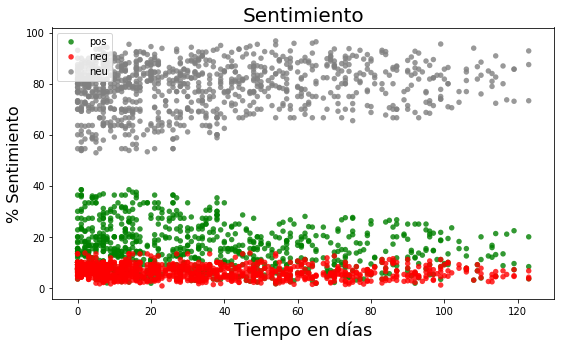

- Incidencias No Resueltas


>>> Days VS Sent
POS:  (-0.273803896674789, 0.0014891857686569398)
NEG:  (-0.2952276611516172, 0.0005891172764838817)
NEU:  (0.3201536862716721, 0.00018234767180667886)
Comms:  2752
Issues:  132
Comms >  10


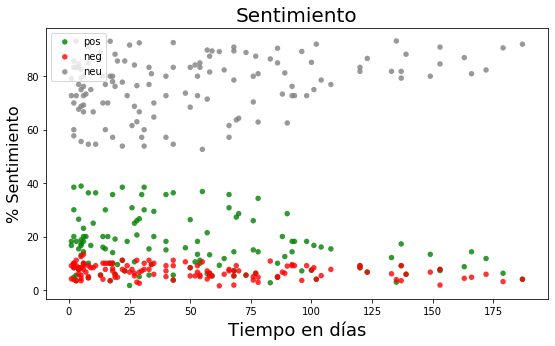

'\ng1 = (globDevs, globSentPOS)\ng2 = (globDevs, globSentNEG)\ng3 = (globDevs, globSentNEU)\n\ndata = (g1, g2, g3)\ncolors = ("green", "red", "grey")\ngroups = ("pos", "neg", "neu")\n\nfig = plt.figure()\nax = fig.add_subplot(1, 1, 1)\n\nfor data, color, group in zip(data, colors, groups):\n    if group == \'neu\' or group == \'pos\':\n        continue\n    x, y = data\n    x, y = np.array(x), np.array(y)\n    m, b = np.polyfit(x, y, 1)\n    plt.plot(x, m*x + b)\n    ax.scatter(x, y, alpha=0.8, c=color, edgecolors=\'none\', s=30, label=group)\n\nplt.title(\'Devs VS Sent\')\nplt.legend(loc=2)\nplt.show()\n'

In [31]:
# Scatter Plot Corr Pearson
globDevs_ID, globDays_ID, globSentPOS_ID, globSentNEG_ID, globSentNEU_ID = [], [], [], [], [] 
globDevs_IND, globDays_IND, globSentPOS_IND, globSentNEG_IND, globSentNEU_IND = [], [], [], [], [] 


#********************************************** ID Days VS Sent

print('- Incidencias Resueltas ')
numComs = '10'
sentimentsAndIssueResolutionTime(comsPerIssuesArr[numComs], 'ID')
print('Issues: ', len(globDevs_ID))
print('Comms > ', numComs)

g1 = (globDays_ID, globSentPOS_ID)
g2 = (globDays_ID, globSentNEG_ID)
g3 = (globDays_ID, globSentNEU_ID)

data = (g1, g2, g3)
colors = ("green", "red", "grey")
groups = ("pos", "neg", "neu")

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
    # Descomments to plor only one sentiment at the time
    #if group == 'neu' or group == 'pos':
    #    continue
    x, y = data
    x, y = np.array(x), np.array(y)
    m, b = np.polyfit(x, y, 1)
    #plt.plot(x, m*x + b)
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Sentimiento', fontsize=20)
plt.xlabel('Tiempo en días', fontsize=18)
plt.ylabel('% Sentimiento', fontsize=16)
plt.legend(loc=2)
plt.show()



#********************************************** IND Days VS Sent

print('- Incidencias No Resueltas')
numComs = '10'
sentimentsAndIssueResolutionTime(comsPerIssuesArr[numComs], 'IND')
print('Issues: ', len(globDevs_IND))
print('Comms > ', numComs)

g1 = (globDays_IND, globSentPOS_IND)
g2 = (globDays_IND, globSentNEG_IND)
g3 = (globDays_IND, globSentNEU_IND)

data = (g1, g2, g3)
colors = ("green", "red", "grey")
groups = ("pos", "neg", "neu")

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
    # Descomments to plor only one sentiment at the time
    #if group == 'neu' or group == 'pos':
    #    continue
    x, y = data
    x, y = np.array(x), np.array(y)
    m, b = np.polyfit(x, y, 1)
    #plt.plot(x, m*x + b)
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Sentimiento', fontsize=20)
plt.xlabel('Tiempo en días', fontsize=18)
plt.ylabel('% Sentimiento', fontsize=16)
plt.legend(loc=2)
plt.show()


#********************************************** Devs VS Sent
'''
g1 = (globDevs, globSentPOS)
g2 = (globDevs, globSentNEG)
g3 = (globDevs, globSentNEU)

data = (g1, g2, g3)
colors = ("green", "red", "grey")
groups = ("pos", "neg", "neu")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
    if group == 'neu' or group == 'pos':
        continue
    x, y = data
    x, y = np.array(x), np.array(y)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Devs VS Sent')
plt.legend(loc=2)
plt.show()
'''





ID: 12.82 7.69 20.0 12.309999999999999 38.464999999999996 -10.774999999999995
IND: 14.29 8.17 20.0 11.83 37.745000000000005 -9.575000000000001


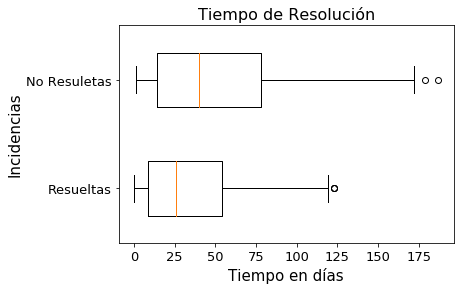

In [29]:
#globDays_ID, globSentPOS_ID, globSentNEG_ID, globSentNEU_ID
#globDays_IND, globSentPOS_IND, globSentNEG_IND, globSentNEU_IND

plt.boxplot([globDays_ID, globDays_IND], vert=False, widths = 0.5)
plt.yticks([1, 2], ['Resueltas', 'No Resuletas'], fontsize=13)
plt.xticks(fontsize=13)
plt.title('Tiempo de Resolución', fontsize=16)
plt.xlabel('Tiempo en días', fontsize=15)
plt.ylabel('Incidencias', fontsize=15)

data = globSentPOS_ID
median = np.median(data)
upper_quartile = np.percentile(data, 75)
lower_quartile = np.percentile(data, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = upper_quartile+1.5*iqr
lower_whisker = lower_quartile-1.5*iqr

print("ID:", median, lower_quartile, upper_quartile, iqr, upper_whisker, lower_whisker)


data = globSentPOS_IND
median = np.median(data)
upper_quartile = np.percentile(data, 75)
lower_quartile = np.percentile(data, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = upper_quartile+1.5*iqr
lower_whisker = lower_quartile-1.5*iqr

print("IND:", median, lower_quartile, upper_quartile, iqr, upper_whisker, lower_whisker)




# Sentiments - Hours of Day

In [30]:
def comsPerIssueFilter(serverProjects, numOfComsPerIssue = 20):
    print('Proyectos: ', serverProjects)
        
    response = []

    for s_p in serverProjects:
            
        issuesFiltered = {}
        issuesData = pd.read_csv('repoDataSA/ISSUES-COMMENTS-' + s_p + '.csv')
        
        for index, row in issuesData.iterrows(): 
            if row.key in issuesFiltered:
                issuesFiltered[row.key]['#'] += 1
                issuesFiltered[row.key]['comments'].append(row) 
            else:
                issuesFiltered[row.key] = {'#': 1, 'comments': [row]}

        for index, rowKey in issuesFiltered.items():
            distroSent = {"#": 0, '1': 0, '-1': 0, '0': 0}   
            if rowKey['#'] >= numOfComsPerIssue:
                for r in rowKey['comments']:
                    response.append(r)
                    
            '''distroSent = {"#": 0, '1': 0, '-1': 0, '0': 0}   
            if rowKey['#'] >= numOfComsPerIssue:
                for r in rowKey['comments']:
                    sent = str(r['sentiment'])
                    distroSent["#"] += 1
                    distroSent[sent] += 1
                
                if distroSent['1'] > 0 or distroSent['-1'] > 0:
                    response.append(r)'''

    return response



#issuesFiltered_0 = pd.DataFrame(comsPerIssueFilter(serversProjectsV1, 0))
issuesFiltered_10 = pd.DataFrame(comsPerIssueFilter(serversProjectsV1, 10))
#issuesFiltered_20 = pd.DataFrame(comsPerIssueFilter(serversProjectsV1, 20))
#issuesFiltered.head()


Proyectos:  ['MONGO-NODE', 'MONGO-PYTHON', 'MONGO-CSHARP', 'MONGO-MONGOID', 'MONGO-PHP', 'MONGO-JAVA', 'MONGO-SERVER', 'MONGO-TOOLS', 'MONGO-RUBY', 'MONGO-WT', 'APACHE-ACCUMULO', 'APACHE-CASSANDRA', 'APACHE-MAPREDUCE', 'APACHE-IGNITE', 'APACHE-STORM', 'APACHE-ATLAS', 'APACHE-BEAM', 'APACHE-DIRSERVER', 'APACHE-FELIX', 'JBOSS-AEROGEAR', 'JBOSS-DROOLS', 'JBOSS-RHBPMS', 'JBOSS-JBAS', 'JBOSS-AS7', 'JBOSS-FUSETOOLS', 'JBOSS-JBPAPP', 'SPRING-STS', 'SPRING-BATCH', 'SPRING-INT', 'SPRING-ROO']


In [33]:
distroSent = {"#": 0, '1': 0, '-1': 0, '0': 0}      

for index, comment in issuesFiltered_10.iterrows():
    sent = str(comment['sentiment'])
    distroSent["#"] += 1
    distroSent[sent] += 1

distroSent['1'] = round((distroSent['1']/distroSent['#'])*100, 2)
distroSent['-1'] = round((distroSent['-1']/distroSent['#'])*100, 2)
distroSent['0'] = round((distroSent['0']/distroSent['#'])*100, 2)

distroSent

{'#': 275954, '1': 12.03, '-1': 2.03, '0': 85.93}

In [34]:

def sentimentsAndHourOfDayBatch(issuesFiltered):
    promAs = {}
    count, sumaComs, promPos, promNeg, promNeu = 0, 0, 0, 0, 0
    MadrugPos, MañanaPos, TardePos, NochePos = [], [], [], []
    MadrugNeg, MañanaNeg, TardeNeg, NocheNeg = [], [], [], []
    MadrugNeu, MañanaNeu, TardeNeu, NocheNeu = [], [], [], []

    sentimentPerHour = sentimentsAndHourOfDay(issuesFiltered)

    for key, value in sentimentPerHour.items():
        if key not in promAs:
            promAs[key] = {'#': 0, '1': 0, '-1': 0, '0': 0}

        promAs[key]['#'] += value['#']
        promAs[key]['1'] += value['1']
        promAs[key]['-1'] += value['-1']
        promAs[key]['0'] += value['0']

    for key, value in promAs.items():
        promAs[key]['1']  = round((value['1'] /value['#']) * 100, 2)
        promAs[key]['-1'] = round((value['-1']/value['#']) * 100, 2)
        promAs[key]['0']  = round((value['0'] /value['#']) * 100, 2)

        promPos  += promAs[key]['1']
        promNeg  += promAs[key]['-1']
        promNeu  += promAs[key]['0']
        sumaComs += value['#']
        count    += 1

        # Madrugada 
        if key <= 5:
            MadrugPos.append(promAs[key]['1'])
            MadrugNeg.append(promAs[key]['-1'])
            MadrugNeu.append(promAs[key]['0'])
            if key == 5:
                print("Madrug\t", sumaComs, "\t", round(promPos/count, 2), '\t', round(promNeg/count, 2), '\t', round(promNeu/count, 2), '\n')
                count, sumaComs, promPos, promNeg, promNeu = 0, 0, 0, 0, 0

        # Mañana 
        if key > 5 and key <= 11: 
            MañanaPos.append(promAs[key]['1'])
            MañanaNeg.append(promAs[key]['-1'])
            MañanaNeu.append(promAs[key]['0'])
            if key == 11:
                print("Mañana\t", sumaComs, "\t", round(promPos/count, 2), '\t', round(promNeg/count, 2), '\t', round(promNeu/count, 2), '\n')
                count, sumaComs, promPos, promNeg, promNeu = 0, 0, 0, 0, 0

        # Tarde 
        if key > 11 and key <= 17: 
            TardePos.append(promAs[key]['1'])
            TardeNeg.append(promAs[key]['-1'])
            TardeNeu.append(promAs[key]['0'])
            if key == 17:
                print("Tarde\t", sumaComs, "\t", round(promPos/count, 2), '\t', round(promNeg/count, 2), '\t', round(promNeu/count, 2), '\n')
                count, sumaComs, promPos, promNeg, promNeu = 0, 0, 0, 0, 0

        # Noche 
        if key > 17 and key <= 23:
            NochePos.append(promAs[key]['1'])
            NocheNeg.append(promAs[key]['-1'])
            NocheNeu.append(promAs[key]['0'])
            if key == 23:
                print("Noche\t", sumaComs, "\t", round(promPos/count, 2), '\t', round(promNeg/count, 2), '\t', round(promNeu/count, 2), '\n')
                count, sumaComs, promPos, promNeg, promNeu = 0, 0, 0, 0, 0

    sentPosDia = [MadrugPos, MañanaPos, TardePos, NochePos] 
    sentNegDia = [MadrugNeg, MañanaNeg, TardeNeg, NocheNeg] 
    sentNeuDia = [MadrugNeu, MañanaNeu, TardeNeu, NocheNeu]
    
    print("\n") 
    
    print("*** SentPos Wilcoxon ")
    print(wilcoxon(MañanaPos, NochePos), "(Mañ-Noc)")
    for sent in range(len(sentPosDia)):
        if sent+1 == len(sentPosDia):
            break;
        print(sent, wilcoxon(sentPosDia[sent], sentPosDia[sent+1]))

    print("*** SentNeg Wilcoxon ")
    for sent in range(len(sentNegDia)):
        if sent+1 == len(sentNegDia):
            break;
        print(sent, wilcoxon(sentNegDia[sent], sentNegDia[sent+1]))

    print("*** SentNeu Wilcoxon ")
    for sent in range(len(sentNeuDia)):
        if sent+1 == len(sentNeuDia):
            break;
        print(sent, wilcoxon(sentNeuDia[sent], sentNeuDia[sent+1]))

    print("\n")   
    print("\n*** promAs: ", promAs, "\n")

    
    
ser_proj = {
        #"issuesFiltered_0": issuesFiltered_0, 
        "issuesFiltered_10": issuesFiltered_10, 
        #"issuesFiltered_20": issuesFiltered_20, 
    }

for index, value in ser_proj.items():
    print("-------------------> ", index, '\n')
    sentimentsAndHourOfDayBatch(value)
    

------------------->  issuesFiltered_10 

Madrug	 47492 	 11.92 	 2.29 	 85.79 

Mañana	 52786 	 12.94 	 2.0 	 85.05 

Tarde	 90088 	 11.9 	 1.97 	 86.14 

Noche	 85588 	 11.66 	 1.96 	 86.38 



*** SentPos Wilcoxon 
WilcoxonResult(statistic=3.0, pvalue=0.11585149752593009) (Mañ-Noc)
0 WilcoxonResult(statistic=1.0, pvalue=0.046399461870904594)
1 WilcoxonResult(statistic=3.0, pvalue=0.11585149752593009)
2 WilcoxonResult(statistic=6.5, pvalue=0.4003808031520797)
*** SentNeg Wilcoxon 
0 WilcoxonResult(statistic=5.0, pvalue=0.24886387493792206)
1 WilcoxonResult(statistic=10.0, pvalue=0.916511907863894)
2 WilcoxonResult(statistic=7.0, pvalue=0.892738400944348)
*** SentNeu Wilcoxon 
0 WilcoxonResult(statistic=4.0, pvalue=0.17295491798842066)
1 WilcoxonResult(statistic=3.0, pvalue=0.11585149752593009)
2 WilcoxonResult(statistic=7.0, pvalue=0.463071015014588)



*** promAs:  {0: {'#': 8667, '1': 12.35, '-1': 2.26, '0': 85.39}, 1: {'#': 8313, '1': 12.23, '-1': 2.49, '0': 85.28}, 2: {'#': 7531,

/Users/andricvaldez/Desktop/Maestria/3er Semestre/Tesis/Desarrollo/env2/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


# Sentiments - Day of Week

In [37]:
def sentimentsAndDayOfWeekBatch(issuesFiltered):
    sentPosLun, sentPosMar, sentPosMie, sentPosJue, sentPosVie, sentPosSab, sentPosDom, sentNegLun, sentNegMar, sentNegMie, sentNegJue, sentNegVie, sentNegSab, sentNegDom, sentNeuLun, sentNeuMar, sentNeuMie, sentNeuJue, sentNeuVie, sentNeuSab, sentNeuDom = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    promAs = {}

    sentimentPerDay = sentimentsAndDayOfWeek(issuesFiltered)

    for key, value in orderWeekDay(sentimentPerDay).items():
        print(key, value)

        if key not in promAs:
            promAs[key] = {'#': 0, '1': 0, '-1': 0, '0': 0}

        promAs[key]['#'] += value['#']
        promAs[key]['1'] += value['1']
        promAs[key]['-1'] += value['-1']
        promAs[key]['0'] += value['0']

        promPos = value['1']/value['#']
        promNeg = value['-1']/value['#']
        promNeu = value['0']/value['#']

        if (key == 'Monday'):
            sentPosLun.append(promPos)
            sentNegLun.append(promNeg)
            sentNeuLun.append(promNeu)

        elif (key == 'Tuesday'):
            sentPosMar.append(promPos)
            sentNegMar.append(promNeg)
            sentNeuMar.append(promNeu)

        elif (key == 'Wednesday'):
            sentPosMie.append(promPos)
            sentNegMie.append(promNeg)
            sentNeuMie.append(promNeu)

        elif (key == 'Thursday'):
            sentPosJue.append(promPos)
            sentNegJue.append(promNeg)
            sentNeuJue.append(promNeu)

        elif (key == 'Friday'):
            sentPosVie.append(promPos)
            sentNegVie.append(promNeg)
            sentNeuVie.append(promNeu)

        elif (key == 'Saturday'):
            sentPosSab.append(promPos)
            sentNegSab.append(promNeg)
            sentNeuSab.append(promNeu)

        elif (key == 'Sunday'):
            sentPosDom.append(promPos)
            sentNegDom.append(promNeg)
            sentNeuDom.append(promNeu)

        else:
            print('error')

    print("\n")
    sentPosSem = [sentPosLun, sentPosMar, sentPosMie, sentPosJue, sentPosVie, sentPosSab, sentPosDom]
    sentNegSem = [sentNegLun, sentNegMar, sentNegMie, sentNegJue, sentNegVie, sentNegSab, sentNegDom]
    sentNeuSem = [sentNeuLun, sentNeuMar, sentNeuMie, sentNeuJue, sentNeuVie, sentNeuSab, sentNeuDom]

    print("\n*** SentPos")
    SentPosSemProms = [round(statistics.mean(dia)*100, 2) for dia in sentPosSem] 
    print("\nSentPosSemProms: ", SentPosSemProms, '\n')
    print(wilcoxon(sentPosMie, sentPosDom), "(Mie-Dom)")
    for sent in range(len(sentPosSem)):
        if sent+1 == len(sentPosSem):
            break;
        print(sent, wilcoxon(sentPosSem[sent], sentPosSem[sent+1]))

    print("\n*** SentNeg")
    SentNegSemProms = [round(statistics.mean(dia)*100, 2) for dia in sentNegSem] 
    print("SentNegSemProms: ", SentNegSemProms, '\n')
    print(wilcoxon(sentNegVie, sentNegDom), "(Vie-Dom)")
    for sent in range(len(sentNegSem)):
        if sent+1 == len(sentNegSem):
            break;
        print(sent, wilcoxon(sentNegSem[sent], sentNegSem[sent+1]))

    print("\n*** SentNeu")
    SentNeuSemProms = [round(statistics.mean(dia)*100, 2) for dia in sentNeuSem] 
    print("SentNeuSemProms: ", SentNeuSemProms, '\n')
    print(wilcoxon(sentNegVie, sentNeuDom), "(Vie-Dom)")
    for sent in range(len(sentNeuSem)):
        if sent+1 == len(sentNeuSem):
            break;
        print(sent, wilcoxon(sentNeuSem[sent], sentNeuSem[sent+1]))

    for key, value in promAs.items():
        promAs[key]['1']  = round((value['1'] /value['#']) * 100, 2)
        promAs[key]['-1'] = round((value['-1']/value['#']) * 100, 2)
        promAs[key]['0']  = round((value['0'] /value['#']) * 100, 2)

    print("\n*** sentimentPerDay", promAs)


ser_proj = {
        #"issuesFiltered_0": issuesFiltered_0, 
        "issuesFiltered_10": issuesFiltered_10, 
        #"issuesFiltered_20": issuesFiltered_20, 
    }

for index, value in ser_proj.items():
    print("-------------------> ", index, '\n')
    sentimentsAndDayOfWeekBatch(value)
    

------------------->  issuesFiltered_10 

Monday {'#': 45048, '1': 5506, '-1': 876, '0': 38666}
Tuesday {'#': 55288, '1': 6599, '-1': 1205, '0': 47484}
Wednesday {'#': 54034, '1': 6537, '-1': 1146, '0': 46351}
Thursday {'#': 53041, '1': 6312, '-1': 1128, '0': 45601}
Friday {'#': 48719, '1': 5968, '-1': 901, '0': 41850}
Saturday {'#': 11386, '1': 1270, '-1': 193, '0': 9923}
Sunday {'#': 8438, '1': 1012, '-1': 162, '0': 7264}



*** SentPos

SentPosSemProms:  [12.22, 11.94, 12.1, 11.9, 12.25, 11.15, 11.99] 

WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415) (Mie-Dom)
0 WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
1 WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
2 WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
3 WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
4 WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
5 WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)

*** SentNeg
SentNegSemProms:  [1.94, 2.18, 2.12, 2.13, 1.85

# Plot Sentiments - Test

      #    pos    neg    neu
0  2376  20.37  25.88  53.75
1  2501  21.51  23.63  54.86
2  2611  19.65  28.23  52.13
3  2385  20.42  26.33  53.25
4  3659  26.73  16.12  57.15
5   335  22.39  29.55  48.06
6   379  25.86  23.22  50.92


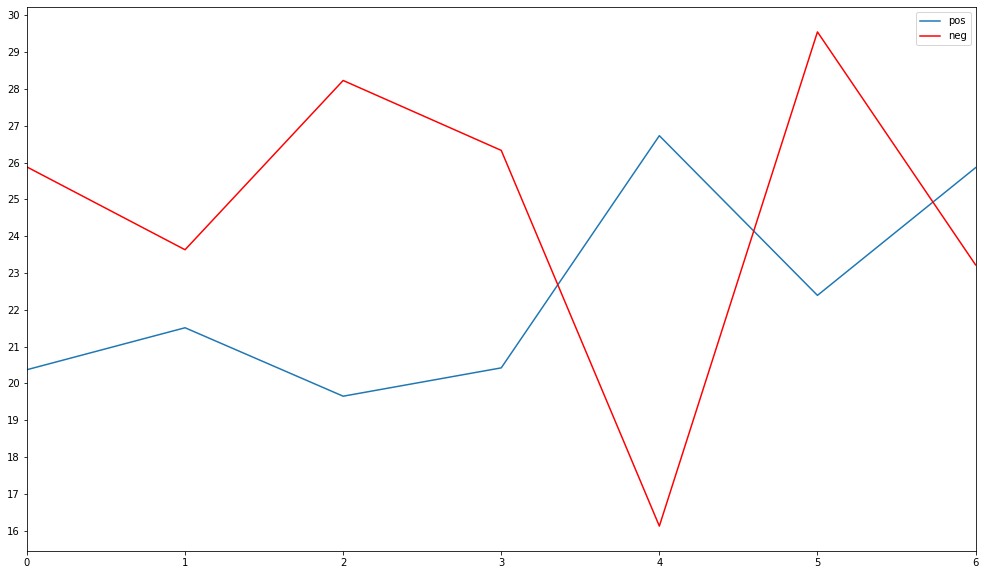

In [177]:
d = {'sentHour': [
            {'#': 2376, 'pos': 20.37, 'neg': 25.88, 'neu': 53.75},
            {'#': 2501, 'pos': 21.51, 'neg': 23.63, 'neu': 54.86},
            {'#': 2611, 'pos': 19.65, 'neg': 28.23, 'neu': 52.13},
            {'#': 2385, 'pos': 20.42, 'neg': 26.33, 'neu': 53.25},
            {'#': 3659, 'pos': 26.73, 'neg': 16.12, 'neu': 57.15},
            {'#': 335, 'pos': 22.39, 'neg': 29.55, 'neu': 48.06},
            {'#': 379, 'pos': 25.86, 'neg': 23.22, 'neu': 50.92}      
        ]
    }

df = pd.DataFrame(d['sentHour'])
print (df)
ax = plt.gca()
#plt.xticks(np.arange(0, 24, 1))
plt.yticks(np.arange(15, 45, 1))


df.plot(kind='line',y='pos',ax=ax, figsize=(17,10))
df.plot(kind='line',y='neg', color='red', ax=ax)

      #    pos  neg    neu
0  3059  17.78  0.0  82.22
1  3399  17.06  0.0  82.94
2  3533  18.06  0.0  81.94
3  3274  18.63  0.0  81.37
4  3075  17.95  0.0  82.05
5   834  16.31  0.0  83.69
6   932  20.60  0.0  79.40


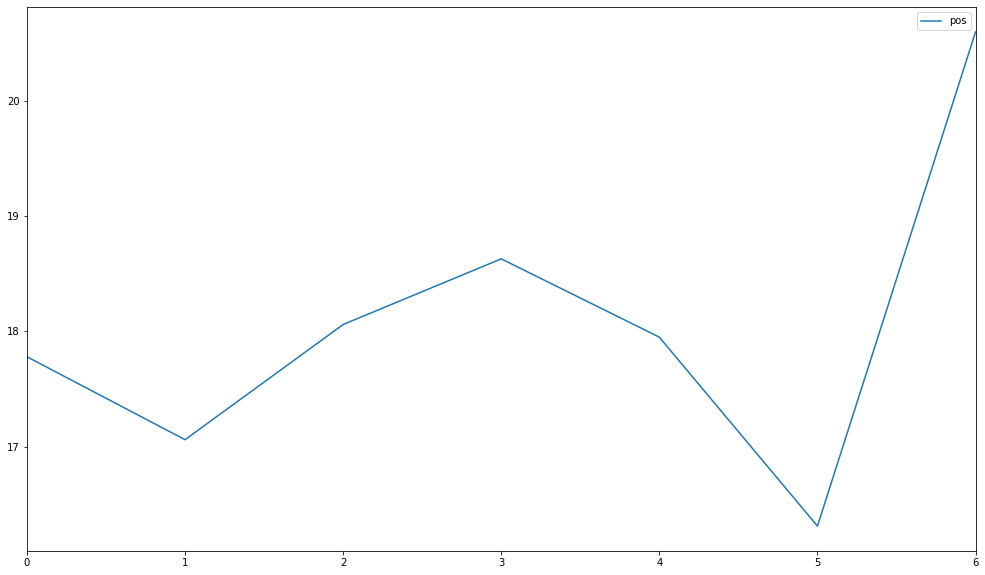

In [184]:
d = {'sentHour': [
            {'#': 3059, 'pos': 17.78, 'neg': 0.0, 'neu': 82.22},
{'#': 3399, 'pos': 17.06, 'neg': 0.0, 'neu': 82.94},
{'#': 3533, 'pos': 18.06, 'neg': 0.0, 'neu': 81.94},
{'#': 3274, 'pos': 18.63, 'neg': 0.0, 'neu': 81.37},
{'#': 3075, 'pos': 17.95, 'neg': 0.0, 'neu': 82.05},
{'#': 834, 'pos': 16.31, 'neg': 0.0, 'neu': 83.69},
{'#': 932, 'pos': 20.6, 'neg': 0.0, 'neu': 79.4}     
        ]
    }

df = pd.DataFrame(d['sentHour'])
print (df)
ax = plt.gca()
#plt.xticks(np.arange(0, 24, 1))
plt.yticks(np.arange(15, 45, 1))


df.plot(kind='line',y='pos',ax=ax, figsize=(17,10))
#df.plot(kind='line',y='neg', color='red', ax=ax)

# Sentiments And IssueType

In [ ]:

def sentimentsAndIssueType(repoProjects):   
    #repoProjects = ["APACHE-CASSANDRA"]
    
    IDPOS, INDPOS, IDNEG, INDNEG = [], [], [], []
    generalPosSent, generalNegSent = [], []
    
    for proj in repoProjects:
        countPos, countNeg, totalPos, totalNeg, totalDone, totalNotDone = 0, 0, 0, 0, 0, 0
        issuesDonePos, issuesDoneNeg, issuesNotDonePos, issuesNotDoneNeg = [], [], [], [];
        issuesResolution, comsPerIssues, issuesType, issues = {}, {}, {}, {}

        #comts = pd.read_csv('../' + tool + '/ISSUES-COMMENTS-' + repository + '-' + proj + '.csv')
        comts = pd.read_csv('repoDataSA/ISSUES-COMMENTS-' + proj + '.csv')
        comts = comts.sort_values(by=['issueComDate'])

        print('\n********************************************', proj)
        numCom = len(comts)
        print('>>> Number of comments:', numCom)
        print(comts['sentiment'].value_counts('1')*100)
        
        for index, comment in comts.iterrows():
            
            #if comment.issuetype == 'Bug':
            
        # Get Issues Done and Not Done  
            if (comment.issueResolution in issuesResolutionDone and comment['sentiment'] == 1):
                issuesDonePos.append(comment)

            if (comment.issueResolution in issuesResolutionDone and comment['sentiment'] == -1):
                issuesDoneNeg.append(comment)

            if (comment.issueResolution in issuesResolutionNotDone and comment['sentiment'] == 1):
                issuesNotDonePos.append(comment)

            if (comment.issueResolution in issuesResolutionNotDone and comment['sentiment'] == -1):
                issuesNotDoneNeg.append(comment)

        # Get Issues Resolutions  
            if comment.issueResolution in issuesResolution:
                issuesResolution[comment.issueResolution]['#'] += 1     
                issuesResolution[comment.issueResolution][str(comment['sentiment'])] += 1                   
            else:
                issuesResolution[comment.issueResolution] = {'#': 1, '1': 0, '-1': 0, '0': 0}
                issuesResolution[comment.issueResolution][str(comment['sentiment'])] += 1

        # Get Issues Types  
            if comment.issuetype in issuesType:
                issuesType[comment.issuetype]['#'] += 1     
                issuesType[comment.issuetype][str(comment['sentiment'])] += 1     
            else:
                issuesType[comment.issuetype] = {'#': 1, '1': 0, '-1': 0, '0': 0, "ID": 0, "IND": 0}
                issuesType[comment.issuetype][str(comment['sentiment'])] += 1
        
        # Get Pos and Neg Percentage for all comments 
            if(comment['sentiment'] == 1):
                countPos += 1

            if(comment['sentiment'] == -1):
                countNeg += 1

       # Get Issues
            if comment.key not in issues:
                issues[comment.key] =  comment
        
        print("\n>>> Project Sentiment Distro")
        perPos = countPos/numCom * 100
        generalPosSent.append(perPos)
        print("% Pos: ", round(perPos, 2), " --- ", countPos)
        perNeg = countNeg/numCom * 100
        generalNegSent.append(perNeg)
        print("\n% Neg: ", round(perNeg, 2), " --- ", countNeg)

        totalPos = len(issuesDonePos) + len(issuesNotDonePos) 
        totalNeg = len(issuesDoneNeg) + len(issuesNotDoneNeg)
        
        totalDone = len(issuesDonePos) + len(issuesDoneNeg)
        totalNotDone = len(issuesNotDonePos) + len(issuesNotDoneNeg) 
        
        print("\n>>> ID and IND Sentiment Distro Per Comment")
        print("      Pos(", totalPos, ")", "\tNeg(", totalNeg, ")")
        res1 = round((len(issuesDonePos)/totalPos)*100, 2) if totalPos else 0
        res2 = round((len(issuesDoneNeg)/totalNeg)*100, 2) if totalNeg else 0
        res3 = round((len(issuesNotDonePos)/totalPos)*100, 2) if totalPos else 0
        res4 = round((len(issuesNotDoneNeg)/totalNeg)*100, 2) if totalNeg else 0
        print("ID   ", res1, '\t\t', res2)
        print("IND  ", res3, '\t\t', res4)
        
        IDPOS.append(res1)
        IDNEG.append(res2)
        INDPOS.append(res3)
        INDNEG.append(res4)
        
        countID, countIND, sumPromPosID, sumPromNegID, sumPromPosIND, sumPromNegIND = 0, 0, 0, 0, 0, 0
        for key, value in issuesResolution.items():
            issuesResolution[key]['1']  = round((value['1']/value['#']) * 100, 2)
            issuesResolution[key]['-1'] = round((value['-1']/value['#']) * 100, 2)
            issuesResolution[key]['0']  = round((value['0']/value['#']) * 100, 2)
            
            if key in issuesResolutionDone:
                sumPromPosID += value['1'] 
                sumPromNegID += value['-1'] 
                countID += 1
            if key in issuesResolutionNotDone:
                sumPromPosIND += value['1'] 
                sumPromNegIND += value['-1'] 
                countIND += 1
        
        print ("\n>>> Issues Resolution (", len(issuesResolution), ")")
        print("      Pos ", "\tNeg ")
        print("ID:  ", round(sumPromPosID/countID, 2), "\t", round(sumPromNegID/countID, 2))
        print("IND: ", round(sumPromPosIND/countIND, 2), "\t", round(sumPromNegIND/countIND, 2))
        print ("\n", issuesResolution)
        
        for key, value in issuesType.items():
            issuesType[key]['1']  = round(issuesType[key]['1']/issuesType[key]['#'] * 100, 2)
            issuesType[key]['-1'] = round(issuesType[key]['-1']/issuesType[key]['#'] * 100, 2)
            issuesType[key]['0']  = round(issuesType[key]['0']/issuesType[key]['#'] * 100, 2)
        
            for key2, value2 in issues.items():
                if ((issues[key2].issueResolution in issuesResolutionDone) and (issues[key2].issuetype == key)):
                    issuesType[key]['ID'] += 1 
                if ((issues[key2].issueResolution in issuesResolutionNotDone) and (issues[key2].issuetype == key)):
                    issuesType[key]['IND'] += 1 
        
        print ("\n>>> Issues Type (", len(issuesType), ")\n", issuesType) 
        print ("\n")
    

    print("\n>>> Global Sentiment Distro ")
    print("% Pos: ", round(statistics.mean(generalPosSent), 2))
    print("\n% Neg: ", round(statistics.mean(generalNegSent), 2))
    
    print("\n>>> ID and IND Sentiment Distro")
    print("      Pos", "\tNeg")
    print("ID   ", round(statistics.mean(IDPOS), 2), '\t', round(statistics.mean(IDNEG), 2))
    print("IND  ", round(statistics.mean(INDPOS), 2), '\t', round(statistics.mean(INDNEG), 2))
       
        
sentimentsAndIssueType(serversProjectsV1)


# SEOSS 33 dataset

In [204]:
import sqlite3

data = sqlite3.connect('archiva.sqlite3')
data

In [243]:
issue = pd.read_sql_query("SELECT * FROM issue", data)
issue_comment = pd.read_sql_query("SELECT * FROM issue_comment", data)

issue.shape, issue_comment.shape



((1929, 17), (5050, 6))

In [244]:
cnts = issue_comment['issue_id'].value_counts()
newIssue = []

for key, row in issue.iterrows():
    if row['issue_id'] in cnts.index:
        row['cmts'] = cnts[row['issue_id']]
    newIssue.append(row)

issue = pd.DataFrame(newIssue)       
issue.head()       

,issue_id,type,created_date,created_date_zoned,updated_date,updated_date_zoned,resolved_date,resolved_date_zoned,summary,description,priority,status,resolution,assignee,assignee_username,reporter,reporter_username,cmts
0,MRM-436,Bug,2007-07-29T23:57:05.783Z,2007-07-29T23:57:05.783Z,2007-08-17T02:02:40.205Z,2007-08-17T02:02:40.205Z,2007-08-17T02:02:40.208Z,2007-08-17T02:02:40.208Z,incorrect default cron expression for snapshot...,it is '0 0' which is not a valid value - it sh...,Major,Closed,Fixed,Maria Odea Ching,oching,Brett Porter,brettporter,3.0
1,MRM-421,Bug,2007-06-22T08:43:41.005Z,2007-06-22T08:43:41.005Z,2007-06-22T23:07:57.626Z,2007-06-22T23:07:57.626Z,2007-06-22T23:07:57.631Z,2007-06-22T23:07:57.631Z,Default configuration does not proxy the centr...,Testing the fix for MRM-370...\n\nrm -rf $M2_R...,Major,Closed,Fixed,Wendy Smoak,wsmoak,Wendy Smoak,wsmoak,1.0
2,MRM-415,Bug,2007-06-17T16:50:33.458Z,2007-06-17T16:50:33.458Z,2010-04-05T11:32:28.009Z,2010-04-05T11:32:28.009Z,2007-06-17T18:30:39.416Z,2007-06-17T18:30:39.416Z,[MySQL] Specified key was too long; max key le...,When starting up archiva on a MySQL Database. ...,Major,Closed,Fixed,None,None,Joakim Erdfelt,joakime,3.0
3,MRM-485,Bug,2007-08-27T14:06:54.3Z,2007-08-27T14:06:54.3Z,2007-08-28T01:11:57.595Z,2007-08-28T01:11:57.595Z,2007-08-28T01:11:57.6Z,2007-08-28T01:11:57.6Z,"Unable to create a ""snapshot only"" repository.",1- Create or edit any repository\n2- Uncheck t...,Major,Closed,Duplicate,None,None,Oscar Picasso,oscarpica,2.0
4,MRM-488,Bug,2007-08-29T04:57:08.063Z,2007-08-29T04:57:08.063Z,2007-12-04T08:08:26.218Z,2007-12-04T08:08:26.218Z,2007-09-28T18:27:35.517Z,2007-09-28T18:27:35.517Z,properties in pom are not resolved (at least w...,I extensively use properties in pom.xml (see a...,Major,Closed,Fixed,Joakim Erdfelt,joakime,Libor Kramolis,libor.kramolis,2.0


In [253]:
count = 0
for key, com in issue_comment.iterrows():
    if com['issue_id'] == 'MRM-980':
        count += 1
        print(count, '--> ', com['message'], '\n')
        

1 -->  SourceArtifact class is responsible for retuning artifact metadata to the caller of a given repo id to the caller. here we can get the artifact meta data of the source artifacts in the repository that we are going to merge. caller has to first get the Artifacts object list and then parse artifacts to get the Artifact metadata  list 

2 -->  Proposal for this is in:

https://cwiki.apache.org/confluence/display/ARCHIVA/Staging+Repository+Merge 

3 -->  ongoing stage-repo-merging module  

4 -->  path for stage repo merge  

5 -->  Comments on the patch:
* the log4j.xml config in src/main/resources can already be removed, just use sl4fj logger for logging instead
* remove dependency to archiva-xmlrpc-api, you shouldn't be using the Artifact class in that module since it's specifically for web services only. I think you should use the new repository API instead.
* remove the commented out dependencies in the stage-repository-merge module
* apply codestyle 

6 -->  For the SourceArti